# Exercise 02: Markov Decision Processes

In this exercise, we want to look at markov decision processes (MDP) and how to model and use them.



In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

A MDP is modelled by states and transition between states through the function

$$\def\Pr#1{{{\mathrm{Pr}\!}\left\{#1\right\}}}p(s',r|s,a) \doteq \Pr{S_t\!=\!s', R_t\!=\!r\;|\;S_{t-1}\!=\!s, A_{t-1}\!=\!a}$$

We will model this in a class for a state that contains the list of transitions for each actions. Each transition contains the next state and the corresponding reward.

Please study the definition of the class below.

In [3]:
class RState:
    """
    State in a stochastic MDP. Each action can result in different states and rewards.
    """

    def __init__(self, state_id):
        self._state_id = state_id
        # each transition is tuple with (probability, next_state, reward)
        # for each action, we have a list of transitions
        self._transitions = {}
        self._is_terminal = False

    @property
    def state_id(self):
        return self._state_id

    @property
    def is_terminal(self) -> bool:
        return self._is_terminal

    @is_terminal.setter
    def is_terminal(self, value):
        self._is_terminal = value

    def add_transition(self, action, next_state, reward, probability):
        """
        Add a transition to the state.
        Args:
            action: action for which the transition is added
            next_state: the next state after taking the action
            reward: the reward for taking the action
            probability: the probability of the transition
        """
        if action not in self._transitions:
            self._transitions[action] = []
        self._transitions[action].append([probability, next_state, reward])

    def add_transition_rescale(self, action, next_state, reward, probability):
        """
        Add a transition to the state with the give probability and rescale all other transition probabilities
        so that the probabilities sum to 1.0.

        Args:
            action: action for which the transition is added
            next_state: the next state after taking the action
            reward: the reward for taking the action
            probability: the probability of the transition
        """
        if action not in self._transitions:
            self._transitions[action] = []

        # check if the previous transitions sum to 1.0, if not they need to be rescaled for that too
        sum_prob = 0.0
        for p, _, _ in self._transitions[action]:
            sum_prob += p
        scale = 1.0 / sum_prob
        scale *= (1.0 - probability)
        transitions = self._transitions[action]
        for i in range(len(transitions)):
            transitions[i][0] *= scale
        self._transitions[action].append((probability, next_state, reward))

    def take_action(self, action) -> (int, float):
        """
            Take an action in the state to get the next state and reward
        Args:
            action: the action to take

        Returns:
            the next state and reward
        """
        if self._is_terminal:
            raise Exception("Action on terminal state")

        # select a transition according to the probabilities
        transitions = self._transitions[action]
        probabilities = [p for p, _, _ in transitions]
        index = np.random.choice(len(transitions), p=probabilities)
        _, next_state, reward = transitions[index]
        return next_state, reward

## Defining an MDP

Using the class above, we would like to model the MDP given by the following diagram

<div>
<img src="MDP.png" width="40%"/>
</div>

where s2 is a terminal state. 
So for example for action $a_0$ in $S_0$, there is a 70% change to reach state $S_1$ and a 30% change to stay in state $S_0$.

Add the necessary commands to create that MDP. All actions give a reward of -1.

In [4]:
# states
s0 = RState(0)
s1 = RState(1)
s2 = RState(2)

# actions
a0 = 0
a1 = 1

# YOUR CODE HERE
s0.add_transition(a0, s1, -1, 1)
s0.add_transition_rescale(a0, s0, -1, 0.7)
s0.add_transition(a1, s2, -1, 1)
s0.add_transition_rescale(a1, s0, -1, 0.5)

s1.add_transition(a0, s1, -1, 0.2)
s1.add_transition(a0, s2, -1, 0.8)

s1.add_transition(a1, s0, -1, 0.6)
s1.add_transition(a1, s1, -1, 0.4)

s2._is_terminal = True






In [5]:
assert s2.is_terminal
assert not s0.is_terminal
assert not s1.is_terminal

assert len(s0._transitions) == 2
assert len(s0._transitions[a0]) == 2

t0 = s0._transitions[a0][0]
t1 = s0._transitions[a0][1]
assert t0[0] == 0.3 or t1[0]==0.7
assert t0[2] == -1
assert t0[1] == s1 or t1[1] == s1

## Policy function

Now we want to define a policy for this MDP. A policy defines a probability for each action in each state. We want to start with a uniformely random policy, so that each action has the same probability.


Define an appropriate matrix using numpy. As $S_2$ is a terminal state, there can never be an action taken in this states. The only states with actions are $S_0$ and $S_1$, and the possible actions for both states are $A_0$ and $A_1$. Use the state as the first index in the matrix and the action as the second.



In [6]:
policy = None

# Redefine the policy variable
# YOUR CODE HERE
policy = np.array([[0.5,0.5],[0.5,.5]])


In [7]:
assert policy.shape == (2,2)
assert policy[0,1] == 0.5

## Episodes

In the next few lectures we will encounter episodes. An episode is a sequence of states (and rewards) until a terminal state is reached. 

We want to calculate different episodes and print the results.

Complete the function sample_episode below. It should return a sequence of state ids and the return (sum of the rewards) of the episode. We will not use reward discounting in this example. The possible actions are always numbered 0, 1 etc. 


In [8]:
def sample_episode(start: RState, policy) -> ([], float):
    s = start
    r = 0
    nr_actions = policy.shape[1]
    
    # the trajectory is a list of [state_id, action, reward] lists for each state taken
    trajectory = []
    # YOUR CODE HERE
    
    while s._is_terminal == False:
        possible_actions = policy[s.state_id]
        #choose action 0 or 1 with possibilies inside matrix
        choosen_action = np.random.choice(nr_actions, p=possible_actions)
        next_state, reward = s.take_action(choosen_action)
        trajectory.append([s, choosen_action, reward])
        r += reward
        s = next_state
    
    return trajectory, r

In [9]:
t, r = sample_episode(s0, policy)
print(t, r)
assert len(t) >= 1
assert r <= -1.0

results = []
for i in range(100):
    t, r = sample_episode(s0, policy)
    results.append(r)

r_array = np.array(results)
mean = np.mean(r_array)
print(mean)

assert mean < -1.0

[[<__main__.RState object at 0x7f7b01fc5820>, 1, -1]] -1
-4.01


A random policy is certainly not optimal, so we would like to find a optimal one. But as we do yet know how to calculate an optimal policy, we will have to guess.

There are 2 possiblities:
* We always take action $A_1$ in $S_0$, and either reach $S_2$ immediately with 50% chance, or stay in $S_0$ and try again.
* We take action $A_0$ in $S_0$ and again in $S_1$. This gives as a higher chance to reach the next state, but it takes 2 steps. We never want to take action $A_1$ in $S_1$ as this would put us back to the start state.


Implement both these policies and calculate the mean return over 100 episodes? Which one is better?

In [10]:
# Change the policy, so that it is optimal
policy_0 = np.zeros((2, 2))
policy_1 = np.zeros((2, 2))

# fill in the policies
# YOUR CODE HERE
policy_0 = np.array([[0,1], [0.5,0.5]])
policy_1 = np.array([[1,0], [1,0]])


In [11]:
def evaluate_policy(policy, start):
    results = []
    for i in range(100):
        t, r = sample_episode(start, policy)
        results.append(r)
    r_array = np.array(results)
    return np.mean(r_array)


mean_0 = evaluate_policy(policy_0, s0)
mean_1 = evaluate_policy(policy_1, s0)

assert mean_0 < -1.0
assert mean_1 < -1.0
print(mean_0, mean_1)

-1.84 -5.15


It seems that the first policy is better.

In the lecture, we have seen that we can solve a MDP using a system of equations. If we only look at state $S_0$, can you write and solve the equation for that state?

What is the value function for $S_0$? Type your value in the next cell.

## Gridworld environment

We would like to use a gridworld environment in some of the exercises. Using the state class above, the following class definition defines a gridworld where an action in each direction (N, E, S, W) takes you to the neighboring cell except on the border where you stay in the same position.



In [12]:

class MDPGridworld:
    """
    MDP describing a gridworld.

    - States are (logically) distributed in a grid of size width x height
    - States are kept in 1D array by their state id
    - Actions are up, down, left, right (N, S, W, E)
    - Actions take you to the neighboring state per default, unless you are at the border
    - Action behaviour can be changed to be stochastic, or to transition to a different state

    - The origin of the coordinate system is in the upper left corner with x0 going down and x1 going right
    - This corresponds to the matrix indexing in numpy

    """
    N = 0
    E = 1
    S = 2
    W = 3
    NR_ACTIONS = 4

    def __init__(self, height, width):
        self._height = height
        self._width = width
        self._states = np.empty((height * width), dtype=object)

        # create the states first
        for x0 in range(self._height):
            for x1 in range(self._width):
                state_id = self.pos_to_id(x0, x1)
                s = RState(state_id)
                self._states[state_id] = s

        # create the transitions
        for x0 in range(self._height):
            for x1 in range(self._width):
                state_id = self.pos_to_id(x0, x1)
                s = self._states[state_id]

                # make a default grid with 4 actions for each state and connections to the neighbors
                # North
                if x0 != 0:
                    s.add_transition(self.N, self._states[self.pos_to_id(x0 - 1, x1)], -1.0, 1.0)
                else:
                    s.add_transition(self.N, self._states[self.pos_to_id(x0, x1)], -1.0, 1.0)

                # South
                if x0 != self._height - 1:
                    s.add_transition(self.S, self._states[self.pos_to_id(x0 + 1, x1)], -1.0, 1.0)
                else:
                    s.add_transition(self.S, self._states[self.pos_to_id(x0, x1)], -1.0, 1.0)
                # West
                if x1 != 0:
                    s.add_transition(self.W, self._states[self.pos_to_id(x0, x1 - 1)], -1.0, 1.0)
                else:
                    s.add_transition(self.W, self._states[self.pos_to_id(x0, x1)], -1.0, 1.0)

                # East
                if x1 != self._width - 1:
                    s.add_transition(self.E, self._states[self.pos_to_id(x0, x1 + 1)], -1.0, 1.0)
                else:
                    s.add_transition(self.E, self._states[self.pos_to_id(x0, x1)], -1.0, 1.0)

    def state(self, x0, x1):
        return self._states[self.pos_to_id(x0, x1)]

    def pos_to_id(self, x0, x1) -> int:
        return x1 * self._height + x0

    def id_to_pos(self, id) -> (int, int):
        return id % self._height, id // self._height

    def all_state_ids(self):
        ids = np.zeros((self._height, self._width), dtype=int)
        for x0 in range(self._height):
            for x1 in range(self._width):
                ids[x0, x1] = self.pos_to_id(x0, x1)
        return ids

    def take_action(self, x0, x1, action) -> (int, int, float):
        """
            Take an action in the grid to get the next position and reward.

            Actions can also be performed directly using the underlying state objects. This method is just a
            convenience when you want to use the positions instead.
        Args:
            x0: x0 coordinate of the state
            x1: x1 coordinate of the state
            action: the action to take

        Returns:
            the next state and reward
        """
        state, reward = self._states[self.pos_to_id(x0, x1)].take_action(action)
        x0, x1 = self.id_to_pos(state.state_id)
        return x0, x1, reward


In [13]:
g = MDPGridworld(3, 4)
g.state(0,0).is_terminal = True
for i in range(12):
    assert g.pos_to_id(g.id_to_pos(i)[0],g.id_to_pos(i)[1]) == i


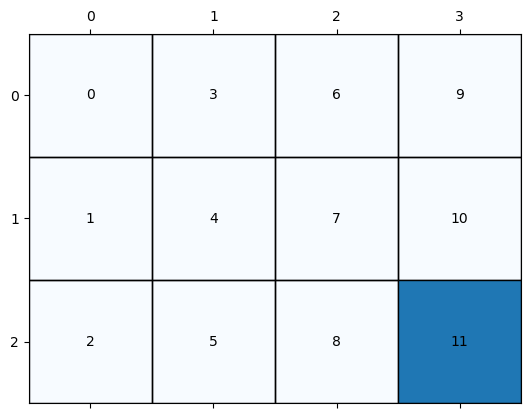

In [14]:
# Let us plot the gridworld
g = MDPGridworld(3, 4)
g.state(2,3).is_terminal = True
ids = g.all_state_ids()

fig, ax = plt.subplots()
ax.matshow(ids, cmap='Blues', vmin=0, vmax=0)
for i in range(ids.shape[0]):
    for j in range(ids.shape[1]):
        c = ids[i,j]
        ax.text(j, i, f'{c:.0f}', va='center', ha='center')

        if g.state(i,j).is_terminal:
            r = plt.Rectangle((j-0.5,i-0.5), 1, 1, fill=True)
            ax.add_patch(r)
        
        r = plt.Rectangle((j-0.5,i-0.5), 1, 1, fill=False)
        ax.add_patch(r)
        

The sample_episode method that you have defined earlier should already work for the states in the gridworld (if not, go back and check how you sample from the action, here you have 4 actions, while you had only 2 before).


Define a uniformely random policy for the gridworld and evaluate how long it will take to reach the terminal state from state(0,0).

In [15]:
policy = None

# generate the correct uniformly random policy for the gridworld


# YOUR CODE HERE
policy = np.full((12,4), 0.25)

In [16]:
start = g.state(0,0)

r = evaluate_policy(policy, start)

print(r)

-38.72


## Bonus exercise: Slippery Gridworld

Using the gridworld above, we want to define a class for the slippery gridworld introduced in the lecture.

On a slippery grid cell, the specified probability defines the probability to fall to the next south position (x0+1). Add the body of the function below.

In [21]:
class SlipperyGridworld(MDPGridworld):
    def add_slippery_patch(self, x0, x1, probability):
        """
        Add a patch of slippery ground to the gridworld. This means that the agent has a chance of slipping down
        one grid position on any of the actions (N, E, W) taken
        Args:
            x0: the x0 coordinate of the patch
            x1: the x1 coordinate of the patch
            probability: the probability to slip and fall one grid position down (S)
        """
        # YOUR CODE HERE
        current_state = self.state(x0, x1)
        
        # if not outside boundary (man m√ºsste theoretisch auch noch testen, ob es ein Grenzzustand an der unteren Grenze ist.
        fallen_state = self.state(x0+1, x1)

        # do for each action in current_state (-1 is reward for all actions)
        current_state.add_transition_rescale(self.N, fallen_state, -1, probability)
        current_state.add_transition_rescale(self.E, fallen_state, -1, probability)
        current_state.add_transition_rescale(self.S, fallen_state, -1, probability)
        current_state.add_transition_rescale(self.W, fallen_state, -1, probability)

In [22]:
gs = SlipperyGridworld(6,3)
gs.add_slippery_patch(3, 2, 0.2)
transitions = gs._states[gs.pos_to_id(3, 2)]._transitions[gs.W]
assert len(transitions) == 2
assert transitions[0][0] == 0.8
assert transitions[1][0] == 0.2